In [1]:
from os import listdir, environ, read
from analysis.plot_matplotlib import plot_hist, plot_confusion
from analysis.mem_ana import load_results, best_threshold, conf_mat, plot_r
from math import pi,sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
reco = pd.DataFrame(np.load("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison_old/npy/reco/compare_reco_with_mg5.npy", allow_pickle=True))

Physsim + SEP_TF

In [3]:
np.random.seed(2023)

results = load_results("/nfs/dust/ilc/user/bliewert/mem_integrate_old/results", reco)

print([
    np.count_nonzero(results["zhh_mem"] > results["zzh_mem"]),
    np.count_nonzero(results["zhh_mem"] < results["zzh_mem"])
], "nMEM(Sig > Bkg), nMEM(Sig < Bkg)")
print([
    np.count_nonzero(results["is_zhh"]),
    np.count_nonzero(results["is_zzh"])
], "nSig : nBkg")

[1602, 2493] nMEM(Sig > Bkg), nMEM(Sig < Bkg)
[490, 3605] nSig : nBkg


In [10]:
reco["true_h1_decay_pdg"].value_counts()

true_h1_decay_pdg
5    28939
Name: count, dtype: int64

In [4]:
results["event"]

25931    25931
25922    25922
25252    25252
26658    26658
24645    24645
         ...  
4640      4640
24033    24033
22669    22669
26437    26437
24297    24297
Name: event, Length: 4095, dtype: int64

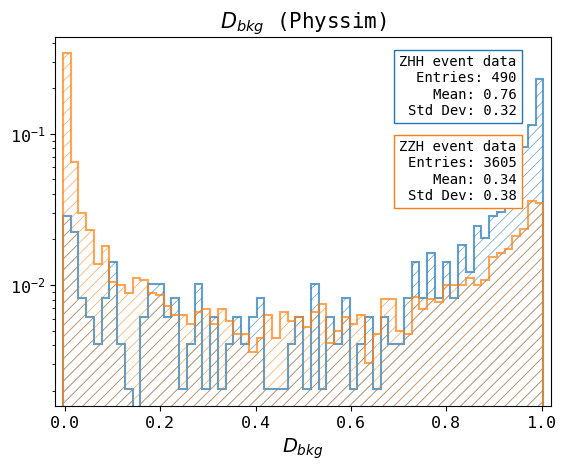

In [4]:
plot_r(results, "Physsim")

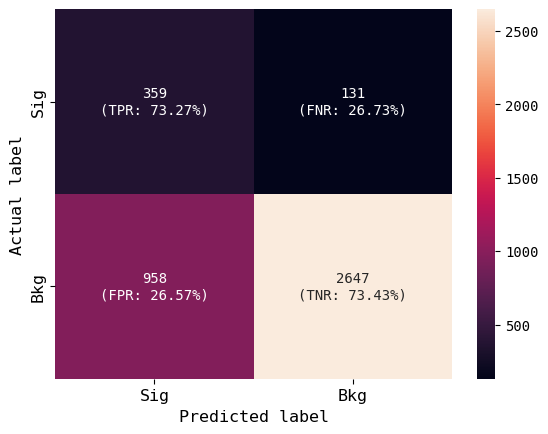

In [5]:
plot_confusion(conf_mat(results, threshold=best_threshold(results, optimization_scheme=2)))

In [4]:
import pandas as pd
import numpy as np
from analysis.mem_ana import constants
 
def best_threshold(results, vals=None, r_column="r", zhh_cross_sec:float=constants["sigma_zhh"], zzh_cross_sec:float=constants["sigma_zzh"], return_df=False, optimization_scheme:int=0):
    """_summary_

    Args:
        results (_type_): _description_
        vals (_type_, optional): _description_. Defaults to None.
        r_column (str, optional): _description_. Defaults to "r".
        zhh_cross_sec (float, optional): _description_. Defaults to constants["sigma_zhh"].
        zzh_cross_sec (float, optional): _description_. Defaults to constants["sigma_zzh"].
        return_df (bool, optional): _description_. Defaults to False.
        optimization_scheme (int, optional): 0: low FN and FP, bkg and sig by ratio of cross-section.

    Returns:
        _type_: _description_
    """
    
    if vals is None:
        vals = np.linspace(np.min(results[r_column]), np.max(results[r_column]), 1000)
    
    best = 9999
    best_t = np.max(results[r_column])
    
    sig_to_bkg = zhh_cross_sec/zzh_cross_sec
    
    result = {
        "TP": [],
        "TN": [],
        "FN": [],
        "FP": []
    }
    
    P = np.count_nonzero((results["is_zhh"]))
    N = np.count_nonzero((results["is_zzh"]))
    
    for thresh in vals:
        TP = np.count_nonzero((results["is_zhh"]) & (results[r_column] > thresh))
        TN = np.count_nonzero((results["is_zzh"]) & (results[r_column] < thresh))

        FN = np.count_nonzero((results["is_zhh"]) & (results[r_column] < thresh))
        FP = np.count_nonzero((results["is_zzh"]) & (results[r_column] > thresh))
        
        PP = TP+FP
        PN = TN+FN
        
        TPR = TP/P
        TNR = TN/N
        
        cur = 0
        if optimization_scheme == 0: # signal/background-ratio as expected
            cur = sqrt((TP - sig_to_bkg*TN)**2) + FN + FP #+ sqrt((FN-FP)**2)
        elif optimization_scheme == 1: # variation of 0
            cur = sqrt((TP - sig_to_bkg*TN)**2) + sqrt(FN**2 + FP**2)
        elif optimization_scheme == 2: # signal/background-ratio as expected, high TPR
            cur = sqrt(((TP - sig_to_bkg*TN)/P)**2) - TPR
        elif optimization_scheme == 3: # high TPR, high TNR 
            cur = -TPR -TNR 
        elif optimization_scheme == 4: # ratio of predicted positive/negative = sig_to_bkg
            if PN == 0:
                cur = 99999
            else:
                cur = (PP/PN - sig_to_bkg)**2            
        else:
            raise Exception("Unknown scheme")
            
        if cur < best:
            best = cur
            best_t = thresh
            
        result["TP"].append(TP)
        result["TN"].append(TN)
        result["FP"].append(FP)
        result["FN"].append(FN)
    
    if return_df:
        return pd.DataFrame(result)
    else:
        return best_t


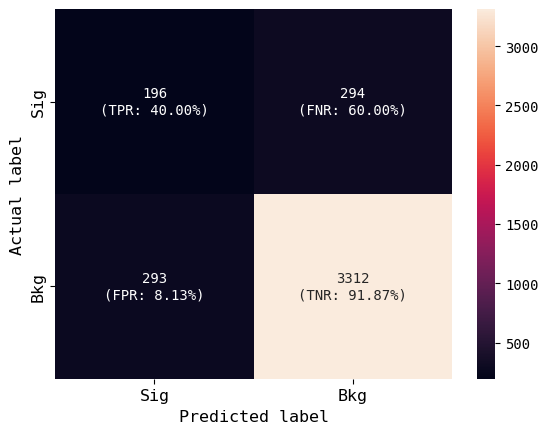

In [19]:
plot_confusion(conf_mat(results, threshold=best_threshold(results, optimization_scheme=4)))

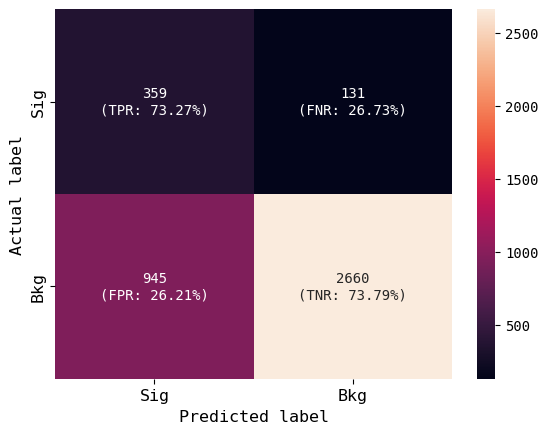

In [20]:
plot_confusion(conf_mat(results, threshold=best_threshold(results, optimization_scheme=3)))

In [5]:
res = best_threshold(results, optimization_scheme=4, return_df=True)
res

,TP,TN,FN,FP
0,490,0,0,3604
1,487,609,3,2996
2,486,771,4,2834
3,485,863,5,2742
4,484,927,6,2678
...,...,...,...,...
995,55,3563,435,42
996,39,3579,451,26
997,24,3589,466,16
998,10,3599,480,6


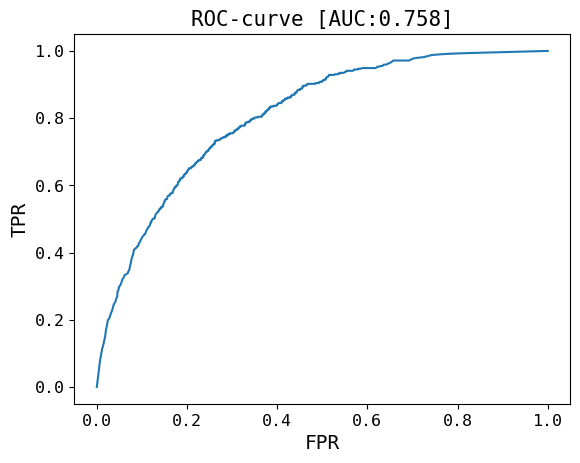

In [6]:
def plot_roc(thresh_df):
    TP = thresh_df["TP"]
    TN = thresh_df["TN"]
    
    FN = thresh_df["FN"]
    FP = thresh_df["FP"]
    
    P = TP + FN
    N = TN + FP
    
    FPR = FP/N
    TPR = TP/P

    fig, ax = plt.subplots()
    plt.plot(FPR, TPR)
    
    AUC = np.sum(TPR)/len(TPR)
    
    #ax.set_xlabel("FPR")
    #ax.set_ylabel("TPR")
    #ax.set_title(f"ROC-curve [AUC:{AUC:.3f}]")
    
    from analysis.plot_matplotlib import plot_styling
    plot_styling(ax, title=f"ROC-curve [AUC:{AUC:.3f}]", xlabel="FPR", ylabel="TPR")
    
    
plot_roc(res)

In [6]:
plot_confusion(conf_mat(results, threshold=0.5))

TypeError: plot_confusion() got an unexpected keyword argument 'normalize'

Physsim

In [10]:
results_mg5 = load_results("/nfs/dust/ilc/user/bliewert/mem_integrate_with_septf/results")

0.3001600651559669

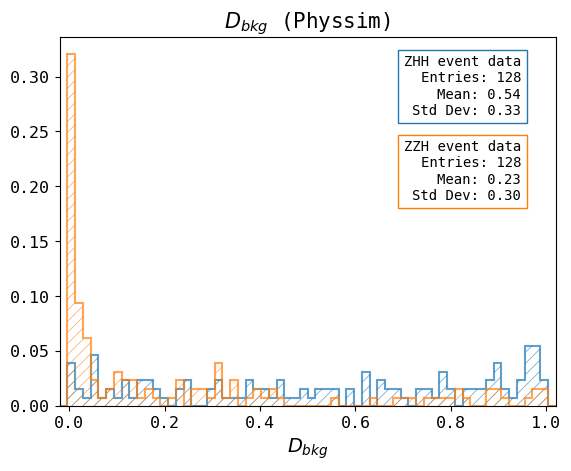

In [11]:
plot_r(results_mg5, "Physsim")
best_ts(results_mg5)

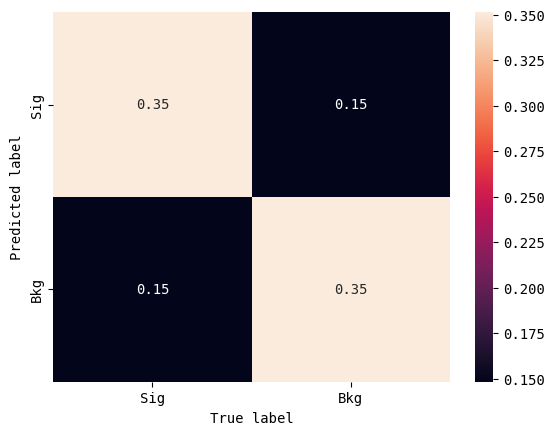

In [13]:
plot_confusion(results_mg5, threshold=0.3001600651559669, normalize=True)

MG5 + SEP-TF

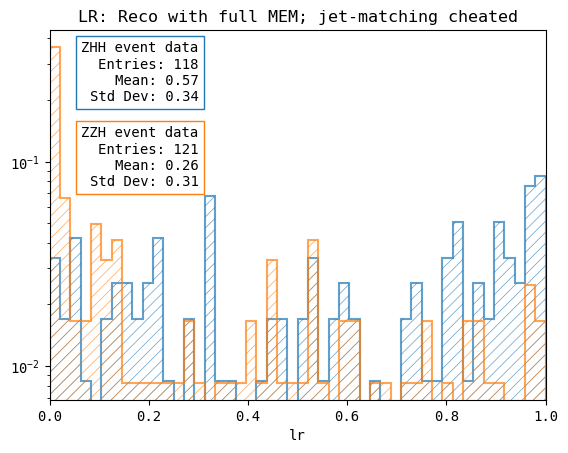

In [24]:
def plot_r(data, name):
    true_zhh, true_zzh = split_true_zhh_zzh(data)

    llr = {
        "zhh_r": true_zhh["r"],
        "zzh_r": true_zzh["r"]
    }

    fig, ax = plt.subplots()
    plot_hist(llr, x = ["zhh_r", "zzh_r"], labels=["ZHH event data", "ZZH event data"], title="LR: {}".format(name), text_start_x= 0.3, normalize=True, xlim=(0.0,1.0), xlim_binning=(0,1.1), xlabel="lr", ax=ax, bins=48, yscale="log")

plot_r(results, "Reco with full MEM; jet-matching cheated")

[Text(0.5, 23.52222222222222, 'Predicted label'),
 Text(50.722222222222214, 0.5, 'True label')]

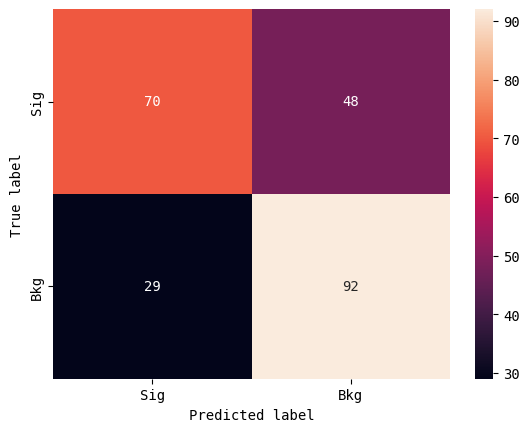

In [19]:
TP = np.count_nonzero((results["is_zhh"]) & (results["r"] > 0.5))
TN = np.count_nonzero((results["is_zzh"]) & (results["r"] < 0.5))

FP = np.count_nonzero((results["is_zhh"]) & (results["r"] < 0.5))
FN = np.count_nonzero((results["is_zzh"]) & (results["r"] > 0.5))

conf_mat = [
    [TP, FP],
    [FN, TN]
]

conf_mat = pd.DataFrame(conf_mat, index=["Sig", "Bkg"], columns=["Sig", "Bkg"])


ax = sns.heatmap(conf_mat, annot=True)
ax.set(xlabel="Predicted label", ylabel="True label")

New

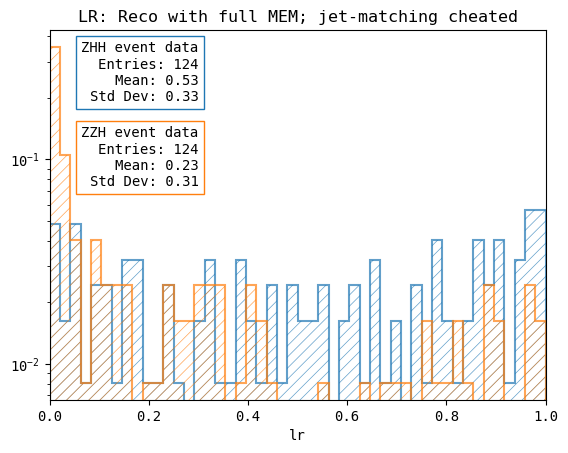

In [5]:
def plot_r(data, name):
    true_zhh, true_zzh = split_true_zhh_zzh(data)

    llr = {
        "zhh_r": true_zhh["r"],
        "zzh_r": true_zzh["r"]
    }

    fig, ax = plt.subplots()
    plot_hist(llr, x = ["zhh_r", "zzh_r"], labels=["ZHH event data", "ZZH event data"], title="LR: {}".format(name), text_start_x= 0.3, normalize=True, xlim=(0.0,1.0), xlim_binning=(0,1.1), xlabel="lr", ax=ax, bins=48, yscale="log")

plot_r(results, "Reco with full MEM; jet-matching cheated")

[Text(0.5, 23.52222222222222, 'Predicted label'),
 Text(50.722222222222214, 0.5, 'True label')]

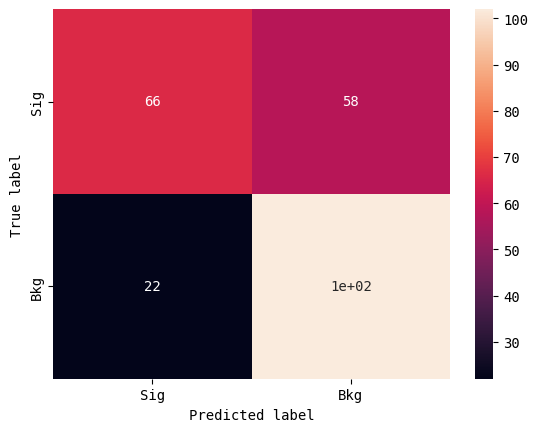

In [6]:
TP = np.count_nonzero((results["is_zhh"]) & (results["r"] > 0.5))
TN = np.count_nonzero((results["is_zzh"]) & (results["r"] < 0.5))

FP = np.count_nonzero((results["is_zhh"]) & (results["r"] < 0.5))
FN = np.count_nonzero((results["is_zzh"]) & (results["r"] > 0.5))

conf_mat = [
    [TP, FP],
    [FN, TN]
]

conf_mat = pd.DataFrame(conf_mat, index=["Sig", "Bkg"], columns=["Sig", "Bkg"])


ax = sns.heatmap(conf_mat, annot=True)
ax.set(xlabel="Predicted label", ylabel="True label")

In [60]:
get_result(event_dir, 24395)

[8.2e-16, 2.84e-19]

Selection of samples

In [19]:
from analysis.mem_ana import constants

np.random.seed(2023)

sig_to_bkg = constants["sigma_zhh"]/constants["sigma_zzh"]
length_tot = 4096

length_bkg = int(length_tot/(1+sig_to_bkg))
length_sig = length_tot-length_bkg

print(length_sig, length_bkg)

zhh_indices = np.argwhere(reco["is_zhh"] == True).flatten()
zzh_indices = np.argwhere(reco["is_zzh"] == True).flatten()

a = np.random.choice(zhh_indices, length_sig, replace=False)
b = np.random.choice(zzh_indices, length_bkg, replace=False)
c = np.concatenate([a, b])

for i in range(len(c)):
    print(c[i])

490 3606
15879
14632
13297
672
11633
15175
9802
17669
20901
21561
6368
19643
20574
19523
20153
3950
7336
17395
9538
13196
8411
19802
6357
1352
17043
12164
17646
16257
14126
10275
4971
20929
4926
8187
20717
1217
20230
7921
4237
13624
15984
15882
7177
10655
9748
13019
13973
7392
7162
12292
21248
19441
14195
18181
14511
7586
8168
9809
6688
4720
3363
2786
6837
3445
18657
7849
8380
17853
120
15659
19739
4800
5800
3514
4664
13802
21828
20134
5038
9837
16605
17907
14395
431
16222
14483
15544
15841
13683
21360
18973
5239
2327
5729
17084
2539
8660
12900
1959
15001
5023
6821
1153
2656
14861
4240
7825
10151
13856
10567
12303
7639
1504
13801
8235
12978
16414
20053
1515
345
17642
15797
14990
13998
20309
7740
21528
20318
16184
16649
18542
7409
6717
22237
13072
21797
1508
5502
16389
5392
5080
13132
20450
16933
610
14111
17275
11778
12328
9174
20466
1832
15294
14122
5685
9498
6501
783
12664
5011
21396
1439
9710
19833
16248
15590
17877
10268
17513
15286
19987
16908
6539
16284
12260
13469
21714
13106
22